## Loading the dataset

In [ ]:
!unzip MUdata.zip

Archive:  MUdata.zip
   creating: MUdata/
  inflating: MUdata/MUestimates_all_locations_1.xlsx  
  inflating: MUdata/MUestimates_all_locations_2.xlsx  
  inflating: MUdata/MUestimates_home_1.xlsx  
  inflating: MUdata/MUestimates_home_2.xlsx  
  inflating: MUdata/MUestimates_other_locations_1.xlsx  
  inflating: MUdata/MUestimates_other_locations_2.xlsx  
  inflating: MUdata/MUestimates_school_1.xlsx  
  inflating: MUdata/MUestimates_school_2.xlsx  
  inflating: MUdata/MUestimates_work_1.xlsx  
  inflating: MUdata/MUestimates_work_2.xlsx  


In [ ]:
import pandas as pd

# 定义不同场所的数据文件
place_files = {
    "all": ["MUdata/MUestimates_all_locations_1.xlsx", "MUdata/MUestimates_all_locations_2.xlsx"],
    "home": ["MUdata/MUestimates_home_1.xlsx", "MUdata/MUestimates_home_2.xlsx"],
    "school": ["MUdata/MUestimates_school_1.xlsx", "MUdata/MUestimates_school_2.xlsx"],
    "work": ["MUdata/MUestimates_work_1.xlsx", "MUdata/MUestimates_work_2.xlsx"],
    "other": ["MUdata/MUestimates_other_locations_1.xlsx", "MUdata/MUestimates_other_locations_2.xlsx"]
}

# 收集每个场所的所有国家 sheet
place_sheets = {}
for place, files in place_files.items():
    sheets = set()
    for f in files:
        xls = pd.ExcelFile(f)
        sheets.update(xls.sheet_names)
    place_sheets[place] = sheets

# 检查交集（所有场所共同的国家）
common_countries = set.intersection(*place_sheets.values())

# 检查缺失
missing = {place: place_sheets[place] - common_countries for place in place_sheets}

print("所有场所共同的国家数:", len(common_countries))
print("示例共同国家:", list(common_countries)[:10])
print("\n每个场所缺失的国家数:")
for k,v in missing.items():
    print(f"{k}: {len(v)} 缺失")


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


所有场所共同的国家数: 152
示例共同国家: ['Mexico', 'Belize', 'Burkina Faso', 'Timor-Leste', 'Zambia', 'Philippines', 'Mongolia', 'Haiti', 'United Republic of Tanzania', 'Jordan']

每个场所缺失的国家数:
all: 0 缺失
home: 0 缺失
school: 0 缺失
work: 0 缺失
other: 0 缺失


### Project 1

Common countries: 152
Example: ['Albania', 'Algeria', 'Andorra', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas']
Loaded matrix for China in home from MUdata/MUestimates_home_1.xlsx with shape (16, 16)


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Loaded matrix for China in school from MUdata/MUestimates_school_1.xlsx with shape (16, 16)


KeyboardInterrupt: 

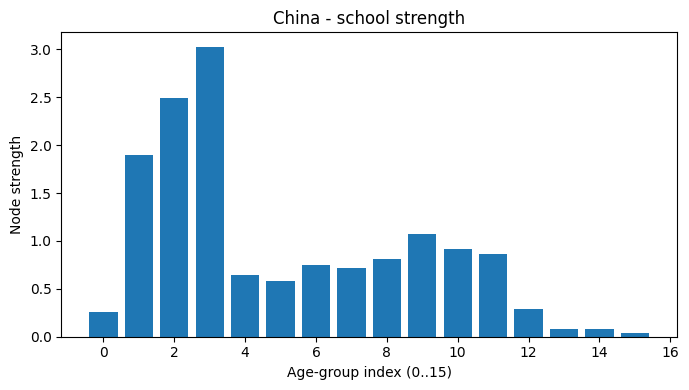

In [ ]:
import os, math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

os.makedirs("outputs", exist_ok=True)

place_files = {
    "all": ["MUdata/MUestimates_all_locations_1.xlsx", "MUdata/MUestimates_all_locations_2.xlsx"],
    "home": ["MUdata/MUestimates_home_1.xlsx", "MUdata/MUestimates_home_2.xlsx"],
    "school": ["MUdata/MUestimates_school_1.xlsx", "MUdata/MUestimates_school_2.xlsx"],
    "work": ["MUdata/MUestimates_work_1.xlsx", "MUdata/MUestimates_work_2.xlsx"],
    "other": ["MUdata/MUestimates_other_locations_1.xlsx", "MUdata/MUestimates_other_locations_2.xlsx"]
}

def union_sheets(files):
    sheets = set()
    for f in files:
        xls = pd.ExcelFile(f)
        sheets.update(xls.sheet_names)
    return sorted(sheets)

place_sheets = {p: set(union_sheets(fs)) for p, fs in place_files.items()}
common_countries = sorted(set.intersection(*place_sheets.values()))
print("Common countries:", len(common_countries))
print("Example:", common_countries[:10])

def load_matrix(place, country):
    for f in place_files[place]:
        xls = pd.ExcelFile(f)
        if country in xls.sheet_names:
            df = pd.read_excel(f, sheet_name=country)
            # Check if the matrix is square
            if df.shape[0] != df.shape[1]:
                print(f"Skipping non-square matrix for {country} in {place} from {f} with shape {df.shape}")
                return None # Return None for non-square matrices
            print(f"Loaded matrix for {country} in {place} from {f} with shape {df.shape}")
            return df.to_numpy(dtype=float)
    print(f"{country} not found in {place}")
    return None # Return None if country not found

def build_graph_from_matrix(M, eps=1e-6):
    W = 0.5*(M + M.T)
    np.fill_diagonal(W, 0.0)
    G = nx.from_numpy_array(W)
    for i, j, data in G.edges(data=True):
        w = data.get('weight', 0.0)
        data['distance'] = 1.0/(w + eps)
    return G

def global_efficiency_weighted(G):
    nodes = list(G.nodes())
    n = len(nodes)
    if n < 2: return 0.0
    length = dict(nx.all_pairs_dijkstra_path_length(G, weight='distance'))
    s = 0.0; cnt = 0
    for i in nodes:
        for j in nodes:
            if i == j: continue
            dij = length[i].get(j, float("inf"))
            if np.isfinite(dij) and dij > 0:
                s += 1.0/dij
                cnt += 1
    return 0.0 if cnt==0 else s/cnt

def diagnostics(G):
    C = nx.average_clustering(G, weight='weight')
    if not nx.is_connected(G):
        Gc = G.subgraph(max(nx.connected_components(G), key=len)).copy()
    else:
        Gc = G
    L = nx.average_shortest_path_length(Gc, weight='distance')
    Eglob_w = global_efficiency_weighted(G)
    strength = dict(G.degree(weight='weight'))
    eig_cent = nx.eigenvector_centrality_numpy(G, weight='weight')
    return {"C": C, "L": L, "Eglob_w": Eglob_w, "strength": strength, "eig_cent": eig_cent}

def matched_ER(G_real, seed=0):
    n = G_real.number_of_nodes()
    m = G_real.number_of_edges()
    p = (2*m)/(n*(n-1)) if n>1 else 0.0
    GER = nx.erdos_renyi_graph(n, p, seed=seed)
    for u,v in GER.edges():
        GER[u][v]['weight'] = 1.0
        GER[u][v]['distance'] = 1.0
    return GER

def matched_WS(G_real, beta=0.1, seed=0):
    n = G_real.number_of_nodes()
    avg_deg = (2*G_real.number_of_edges())/n if n>0 else 2
    k = int(round(avg_deg))
    if k%2==1: k += 1
    k = max(2, min(k, n-1-(n-1)%2))
    Gws = nx.watts_strogatz_graph(n, k, beta, seed=seed)
    for u,v in Gws.edges():
        Gws[u][v]['weight'] = 1.0
        Gws[u][v]['distance'] = 1.0
    return Gws

def benchmark_table(G_real, trials=3, seed=42):
    rows = []
    for t in range(trials):
        GER = matched_ER(G_real, seed=seed+t)
        GWS = matched_WS(G_real, beta=0.1, seed=seed+t)
        d_real = diagnostics(G_real)
        d_er = diagnostics(GER)
        d_ws = diagnostics(GWS)
        rows.append({
            "trial": t,
            "C_real": d_real["C"], "L_real": d_real["L"], "Eglob_w_real": d_real["Eglob_w"],
            "C_ER": d_er["C"], "L_ER": d_er["L"], "Eglob_w_ER": d_er["Eglob_w"],
            "C_WS": d_ws["C"], "L_WS": d_ws["L"], "Eglob_w_WS": d_ws["Eglob_w"],
        })
    return pd.DataFrame(rows)

def plot_heatmap(M, title, fname):
    plt.figure(figsize=(6,5))
    plt.imshow(M, aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Age group (col)")
    plt.ylabel("Age group (row)")
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.close()

def plot_strength_bar(strength, title, fname):
    idx = list(sorted(strength.keys()))
    vals = [strength[i] for i in idx]
    plt.figure(figsize=(7,4))
    plt.bar(idx, vals)
    plt.title(title)
    plt.xlabel("Age-group index (0..15)")
    plt.ylabel("Node strength")
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.close()

def plot_metrics_bars(country, metrics, out_prefix):
    xs = ["home","school","work","other","all"]
    C = [metrics[p]['C'] for p in xs]
    L = [metrics[p]['L'] for p in xs]
    E = [metrics[p]['Eglob_w'] for p in xs]

    plt.figure(figsize=(7,4))
    plt.bar(xs, C)
    plt.title(f"{country} | Clustering by place")
    plt.ylabel("Avg weighted clustering")
    plt.tight_layout()
    plt.savefig(out_prefix + "_C.png", dpi=200)
    plt.close()

    plt.figure(figsize=(7,4))
    plt.bar(xs, L)
    plt.title(f"{country} | Path length by place")
    plt.ylabel("Avg shortest path length (weighted)")
    plt.tight_layout()
    plt.savefig(out_prefix + "_L.png", dpi=200)
    plt.close()

    plt.figure(figsize=(7,4))
    plt.bar(xs, E)
    plt.title(f"{country} | Global efficiency (weighted)")
    plt.ylabel("Eglob_w")
    plt.tight_layout()
    plt.savefig(out_prefix + "_Eglob.png", dpi=200)
    plt.close()

# ---- Select one country per continent (adjust as needed) ----
candidate_countries = ["China", "Canada", "Brazil", "Germany", "Algeria", "Australia"]
countries = [c for c in candidate_countries if c in common_countries]
places = ["home", "school", "work", "other", "all"]

summary_rows = []
for country in countries:
    per_place_metrics = {}
    for p in places:
        M = load_matrix(p, country)
        if M is not None: # Only process if matrix was loaded successfully
            plot_heatmap(M, f"{country} - {p} (raw)", os.path.join("outputs", f"{country}_{p}_heatmap.png"))
            G = build_graph_from_matrix(M)
            d = diagnostics(G)
            per_place_metrics[p] = {"C": d["C"], "L": d["L"], "Eglob_w": d["Eglob_w"]}
            # Save strength bars
            plot_strength_bar(d["strength"], f"{country} - {p} strength", os.path.join("outputs", f"{country}_{p}_strength_bar.png"))
            # Benchmarks
            bench = benchmark_table(G, trials=3, seed=42)
            bench.to_csv(os.path.join("outputs", f"{country}_{p}_benchmarks.csv"), index=False)
            # Summary row
            summary_rows.append({"country": country, "place": p, "C": d["C"], "L": d["L"], "Eglob_w": d["Eglob_w"]})

    # Plot metrics bars only if there is data for the country
    if per_place_metrics:
        plot_metrics_bars(country, per_place_metrics, os.path.join("outputs", f"{country}_bars_metrics"))


summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv("outputs/metrics_summary.csv", index=False)
print("Done. See outputs/ for figures and CSVs.")

In [ ]:
# Contact network analysis with benchmarks and visualization
# ----------------------------------------------------------
# Implements the Methods section:
# - Load MUdata/*.xlsx (Prem et al. contact matrices)
# - Preprocess: symmetrize/fix missing rows
# - Construct weighted graphs
# - Compute diagnostics (C, L, Eglob, degree, strength, centrality)
# - Generate ER/WS/BA benchmarks
# - Compute small-world index S
# - Save visualizations + CSV summaries

import os, math, warnings
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# -------------------------
# Setup
# -------------------------
os.makedirs("outputs", exist_ok=True)

PLACE_FILES = {
    "all": ["MUdata/MUestimates_all_locations_1.xlsx", "MUdata/MUestimates_all_locations_2.xlsx"],
    "home": ["MUdata/MUestimates_home_1.xlsx", "MUdata/MUestimates_home_2.xlsx"],
    "school": ["MUdata/MUestimates_school_1.xlsx", "MUdata/MUestimates_school_2.xlsx"],
    "work": ["MUdata/MUestimates_work_1.xlsx", "MUdata/MUestimates_work_2.xlsx"],
    "other": ["MUdata/MUestimates_other_locations_1.xlsx", "MUdata/MUestimates_other_locations_2.xlsx"],
}

DEFAULT_COUNTRIES = ["China", "Canada", "Brazil", "Germany", "Algeria", "Australia"]
PLACES = ["home","school","work","other","all"]
EPS = 1e-6

# -------------------------
# Data helpers
# -------------------------
def union_sheets(files):
    sheets = set()
    for f in files:
        xls = pd.ExcelFile(f)
        sheets.update(xls.sheet_names)
    return sorted(sheets)

def list_common_countries():
    place_sheets = {p: set(union_sheets(fs)) for p, fs in PLACE_FILES.items()}
    common = sorted(set.intersection(*place_sheets.values()))
    return common, place_sheets

def load_matrix_raw(place, country):
    for f in PLACE_FILES[place]:
        xls = pd.ExcelFile(f)
        if country in xls.sheet_names:
            return pd.read_excel(f, sheet_name=country)
    raise ValueError(f"{country} not found in {place}")

def symmetrize_and_fix(M_df, target_n=16):
    arr = M_df.to_numpy(dtype=float, copy=True)
    r, c = arr.shape
    n = min(r, c)
    if r != c:
        warnings.warn(f"Non-square matrix {r}x{c}, trimming to {n}x{n}")
    W = 0.5*(arr[:n, :n] + arr[:n, :n].T)
    np.fill_diagonal(W, 0.0)
    if n != target_n:
        P = np.zeros((target_n, target_n), dtype=float)
        P[:n, :n] = W
        W = P
    return W

# -------------------------
# Graph + diagnostics
# -------------------------
def build_graph(W):
    G = nx.from_numpy_array(W)
    for u,v,d in G.edges(data=True):
        w = d.get("weight",0.0)
        d["distance"] = 1.0/(w+EPS)
    return G

def weighted_global_efficiency(G):
    nodes = list(G.nodes())
    lengths = dict(nx.all_pairs_dijkstra_path_length(G, weight="distance"))
    num=0; den=0
    for i in nodes:
        for j in nodes:
            if i==j: continue
            dij = lengths[i].get(j, math.inf)
            if math.isfinite(dij) and dij>0:
                num += 1.0/dij
                den += 1
    return 0 if den==0 else num/den

def diagnostics(G):
    C = nx.average_clustering(G, weight="weight")
    Gc = G.subgraph(max(nx.connected_components(G), key=len)).copy() if not nx.is_connected(G) else G
    L = nx.average_shortest_path_length(Gc, weight="distance")
    Eglob = weighted_global_efficiency(G)
    strength = dict(G.degree(weight="weight"))
    deg = dict(G.degree())
    eig = nx.eigenvector_centrality_numpy(G, weight="weight")
    m = G.number_of_edges(); n = G.number_of_nodes()
    density = (2*m)/(n*(n-1)) if n>1 else 0
    avg_k = 2*m/n if n>0 else 0
    return {"C":C,"L":L,"Eglob":Eglob,"strength":strength,"degree":deg,
            "eig":eig,"m":m,"n":n,"density":density,"avg_k":avg_k}

# -------------------------
# Benchmarks
# -------------------------
def matched_ER(n, density, seed=0):
    p = max(0,min(1,density))
    GER = nx.erdos_renyi_graph(n, p, seed=seed)
    for u,v,d in GER.edges(data=True): d.update(weight=1.0,distance=1.0)
    return GER

def matched_WS(n, avg_k, beta=0.1, seed=0):
    k = max(2,int(round(avg_k)))
    if k%2==1: k+=1
    Gws = nx.watts_strogatz_graph(n, k, beta, seed=seed)
    for u,v,d in Gws.edges(data=True): d.update(weight=1.0,distance=1.0)
    return Gws

def matched_BA(n, avg_k, seed=0):
    m = max(1,int(round(avg_k/2)))
    m = min(m,n-1) if n>1 else 1
    Gba = nx.barabasi_albert_graph(n,m,seed=seed)
    for u,v,d in Gba.edges(data=True): d.update(weight=1.0,distance=1.0)
    return Gba

def benchmark_metrics(n,density,avg_k,trials=3,seed=42):
    rows=[]
    for t in range(trials):
        GER = matched_ER(n,density,seed+t)
        GWS = matched_WS(n,avg_k,seed=seed+t)
        GBA = matched_BA(n,avg_k,seed=seed+t)
        rows.append({
            "trial":t,
            **{f"{m}_{lab}": diagnostics(G)[m]
               for lab,G in zip(["ER","WS","BA"],[GER,GWS,GBA])
               for m in ["C","L","Eglob"]}
        })
    return pd.DataFrame(rows)

def small_world_index(C,L,C_er,L_er):
    return np.nan if C_er<=0 or L_er<=0 else (C/C_er)/(L/L_er)

# -------------------------
# Visualization
# -------------------------
def fig_heatmap(M,title,path):
    plt.figure(figsize=(6,5))
    plt.imshow(M,aspect="auto"); plt.colorbar()
    plt.title(title); plt.xlabel("Age group (col)"); plt.ylabel("Age group (row)")
    plt.tight_layout(); plt.savefig(path,dpi=200); plt.close()

def fig_bar_metrics(country,metrics,path_prefix):
    xs=list(metrics.keys())
    for key,label in zip(["C","L","Eglob","S"],
                         ["Clustering","Path length","Global efficiency","Small-world index S"]):
        plt.figure(figsize=(7,4))
        plt.bar(xs,[metrics[p][key] for p in xs])
        plt.title(f"{country} | {label}"); plt.ylabel(label)
        plt.tight_layout(); plt.savefig(path_prefix+f"_{key}.png",dpi=200); plt.close()

def fig_hist(values,title,xlabel,path,bins=10):
    plt.figure(figsize=(7,4))
    plt.hist(values,bins=bins)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel("Count")
    plt.tight_layout(); plt.savefig(path,dpi=200); plt.close()

# -------------------------
# Main analysis
# -------------------------
def analyze(countries=DEFAULT_COUNTRIES, places=PLACES, trials=3, seed=42):
    common,_ = list_common_countries()
    countries = [c for c in countries if c in common]
    print("Analyzing:",countries)

    summary_rows=[]; sw_rows=[]

    for country in countries:
        per_place={}
        for p in places:
            raw = load_matrix_raw(p,country)
            W = symmetrize_and_fix(raw)
            fig_heatmap(W,f"{country} - {p}",f"outputs/{country}_{p}_heatmap.png")
            G = build_graph(W); d = diagnostics(G)
            bench=benchmark_metrics(d["n"],d["density"],d["avg_k"],trials,seed)
            bench.to_csv(f"outputs/{country}_{p}_benchmarks.csv",index=False)
            C_er,L_er=bench["C_ER"].mean(),bench["L_ER"].mean()
            S=small_world_index(d["C"],d["L"],C_er,L_er)
            per_place[p]={"C":d["C"],"L":d["L"],"Eglob":d["Eglob"],"S":S}
            fig_hist(list(d["degree"].values()),f"{country}-{p} degree","Degree",
                     f"outputs/{country}_{p}_deg_hist.png")
            fig_hist(list(d["strength"].values()),f"{country}-{p} strength","Strength",
                     f"outputs/{country}_{p}_strength_hist.png")
            summary_rows.append({"country":country,"place":p,
                                 "C":d["C"],"L":d["L"],"Eglob":d["Eglob"],
                                 "C_ER":C_er,"L_ER":L_er,"S":S})
            sw_rows.append({"country":country,"place":p,"S":S})
        fig_bar_metrics(country,per_place,f"outputs/{country}_bars")

    pd.DataFrame(summary_rows).to_csv("outputs/metrics_summary.csv",index=False)
    pd.DataFrame(sw_rows).to_csv("outputs/small_world_index.csv",index=False)
    print("Done. See outputs/ for CSVs + figures.")

# Run
analyze()

### Project 2

In [ ]:
# ==== INSTALL (only needed once) ====
!pip -q install python-louvain openpyxl

import os, math, json, random, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from community import community_louvain  # python-louvain
from collections import defaultdict

# ------- Matplotlib aesthetics (clean, journal-ready) -------
mpl.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,      # editable text in Illustrator
    "ps.fonttype": 42,
    "axes.spines.top": False,
    "axes.spines.right": False
})

os.makedirs("outputs2", exist_ok=True)

# ---------- DATA paths (no 'all') ----------
place_files = {
    "home":  ["MUdata/MUestimates_home_1.xlsx",            "MUdata/MUestimates_home_2.xlsx"],
    "school":["MUdata/MUestimates_school_1.xlsx",          "MUdata/MUestimates_school_2.xlsx"],
    "work":  ["MUdata/MUestimates_work_1.xlsx",            "MUdata/MUestimates_work_2.xlsx"],
    "other": ["MUdata/MUestimates_other_locations_1.xlsx", "MUdata/MUestimates_other_locations_2.xlsx"],
}
contexts  = ["home","school","work","other"]

def union_sheets(files):
    names = set()
    for f in files:
        xls = pd.ExcelFile(f)
        names.update(xls.sheet_names)
    return names

place_sheets = {p: union_sheets(fs) for p, fs in place_files.items()}
common_countries = sorted(set.intersection(*[set(s) for s in place_sheets.values()]))

candidate_countries = ["China","Canada","Brazil","Germany","Algeria","Australia"]
countries = [c for c in candidate_countries if c in common_countries]
print("Countries used:", countries)

# 16 age-bin midpoints (adjust if yours differ)
ages = np.linspace(2.5, 77.5, 16)

# ---------- IO & Preprocessing ----------
def load_matrix(place, country):
    for f in place_files[place]:
        xls = pd.ExcelFile(f)
        if country in xls.sheet_names:
            M = pd.read_excel(f, sheet_name=country).to_numpy(dtype=float)
            if M.shape[0] != M.shape[1]:
                raise ValueError(f"Matrix not square for {country}-{place}: {M.shape}")
            return M
    raise FileNotFoundError(f"{country} not found in {place}")

def symmetrize_clean(M):
    W = 0.5 * (M + M.T)
    np.fill_diagonal(W, 0.0)
    return W

def A_from_W(W): return W.copy()

def strengths_and_total(A):
    k = A.sum(axis=1)
    two_m = A.sum()
    return k, two_m

def nx_graph_from_A(A):
    G = nx.from_numpy_array(A)
    for u, v, d in G.edges(data=True):
        d['weight'] = float(d.get('weight', 0.0))
    return G

# ---------- Stability VI ----------
def _entropy(labels):
    vals, counts = np.unique(labels, return_counts=True)
    p = counts / counts.sum()
    return -(p * np.log(p + 1e-12)).sum()

def _mi(labels1, labels2):
    l1 = np.array(labels1); l2 = np.array(labels2)
    H1 = _entropy(l1); H2 = _entropy(l2)
    pairs, counts = np.unique(np.c_[l1,l2], axis=0, return_counts=True)
    tot = counts.sum()
    mi = 0.0
    for (a,b), c in zip(pairs, counts):
        pa = (l1 == a).mean(); pb = (l2 == b).mean()
        p = c / tot
        if p>0 and pa>0 and pb>0:
            mi += p * np.log(p / (pa*pb) + 1e-12)
    return mi

def variation_of_information(labels1, labels2):
    H1 = _entropy(labels1); H2 = _entropy(labels2)
    MI = _mi(labels1, labels2)
    return H1 + H2 - 2*MI

# ---------- Louvain multi-run, co-association, consensus & best-of-K ----------
def run_louvain_multi(A, K=150, seed=5660):
    G = nx_graph_from_A(A)
    partitions, Qs = [], []
    rng = np.random.default_rng(seed)
    for _ in range(K):
        part = community_louvain.best_partition(G, weight='weight',
                                                random_state=int(rng.integers(0, 1e9)))
        partitions.append([part[i] for i in range(len(A))])
        Qs.append(community_louvain.modularity(part, G, weight='weight'))
    n = A.shape[0]
    C = np.zeros((n,n), float)
    for g in partitions:
        eq = (np.array(g)[:,None] == np.array(g)[None,:]).astype(float)
        C += eq
    C /= len(partitions)
    return partitions, np.array(Qs), C

def consensus_from_C(C, tau=0.6):
    C_thr = C.copy()
    C_thr[C_thr < tau] = 0.0
    np.fill_diagonal(C_thr, 0.0)
    Gc = nx_graph_from_A(C_thr)
    if Gc.number_of_edges() == 0:
        # 退化情形：全 0 共现，回退为单簇
        part = {i:0 for i in range(C.shape[0])}
    else:
        part = community_louvain.best_partition(Gc, weight='weight', random_state=123)
    return [part[i] for i in range(C.shape[0])]

# ---------- Random null (Chung–Lu, weighted/Poisson) ----------
def expected_P_from_strengths(k, two_m):
    return np.outer(k, k) / (two_m + 1e-12)

def sample_weighted_chung_lu(P, rng):
    n = P.shape[0]
    A = np.zeros_like(P)
    for i in range(n):
        for j in range(i+1, n):
            lam = max(P[i,j], 0.0)
            val = rng.poisson(lam)
            A[i,j] = A[j,i] = val
    np.fill_diagonal(A, 0.0)
    return A

def _safe_Q_from_A(As, rng):
    if As.sum() <= 0: return np.nan
    Gs = nx_graph_from_A(As)
    if Gs.number_of_edges() == 0: return np.nan
    part = community_louvain.best_partition(Gs, weight='weight',
                                            random_state=int(rng.integers(0,1e9)))
    return community_louvain.modularity(part, Gs, weight='weight')

def null_random_distribution(A, R=400, seed=5660, max_tries=40):
    k, two_m = strengths_and_total(A)
    if two_m <= 0:  # 原图就没边
        return np.full(R, np.nan), np.nan, np.nan
    P = expected_P_from_strengths(k, two_m)
    rng = np.random.default_rng(seed)
    Qs = []
    for _ in range(R):
        q = np.nan
        for _try in range(max_tries):
            As = sample_weighted_chung_lu(P, rng)
            q = _safe_Q_from_A(As, rng)
            if not np.isnan(q): break
        Qs.append(q)
    Qs = np.array(Qs, float)
    valid = np.isfinite(Qs)
    if valid.sum() == 0: return Qs, np.nan, np.nan
    return Qs, Qs[valid].mean(), (Qs[valid].std(ddof=1) if valid.sum()>1 else np.nan)

# ---------- Spatial null along age axis (age–distance + IPF) ----------
def fit_age_decay_alpha(A, ages):
    n = A.shape[0]
    xs, ys = [], []
    for i in range(n):
        for j in range(n):
            if i==j: continue
            w = A[i,j]
            if w>0:
                xs.append(abs(ages[i]-ages[j]))
                ys.append(np.log(w))
    if len(xs) < 3:
        return 1.0, 0.0
    X = np.vstack([np.ones(len(xs)), -np.array(xs)]).T
    beta, *_ = np.linalg.lstsq(X, np.array(ys), rcond=None)
    theta0 = np.exp(beta[0]); alpha = beta[1]
    return float(theta0), float(alpha)

def expected_from_age_distance(ages, theta0, alpha):
    n = len(ages)
    E = np.zeros((n,n), float)
    for i in range(n):
        for j in range(n):
            if i==j: continue
            E[i,j] = theta0 * np.exp(-alpha * abs(ages[i]-ages[j]))
    return E

def ipf_match_strengths(E, k_target, max_iter=600, tol=1e-6):
    A = E.copy() + 1e-12
    for _ in range(max_iter):
        A *= (k_target / (A.sum(axis=1)+1e-12))[:,None]
        A *= (k_target / (A.sum(axis=0)+1e-12))[None,:]
        if max(np.abs(A.sum(axis=1)-k_target).max(),
               np.abs(A.sum(axis=0)-k_target).max()) < tol:
            break
    np.fill_diagonal(A, 0.0)
    return A

def spatial_null_distribution(A, ages, R=200, seed=777, max_tries=40):
    k, two_m = strengths_and_total(A)
    if two_m <= 0:
        return np.full(R, np.nan), np.nan, np.nan, (np.nan, np.nan)
    theta0, alpha = fit_age_decay_alpha(A, ages)
    rng = np.random.default_rng(seed)
    Qs = []
    for _ in range(R):
        q = np.nan
        for _try in range(max_tries):
            E = expected_from_age_distance(ages, theta0, alpha)
            A0 = ipf_match_strengths(E, k)
            As = rng.poisson(np.maximum(A0, 0)).astype(float)
            np.fill_diagonal(As, 0.0)
            q = _safe_Q_from_A(As, rng)
            if not np.isnan(q): break
        Qs.append(q)
    Qs = np.array(Qs, float)
    valid = np.isfinite(Qs)
    if valid.sum() == 0: return Qs, np.nan, np.nan, (theta0, alpha)
    return Qs, Qs[valid].mean(), (Qs[valid].std(ddof=1) if valid.sum()>1 else np.nan), (theta0, alpha)

# ---------- Visualization helpers ----------
palette = {
    "home":"#1f77b4", "school":"#2ca02c", "work":"#ff7f0e", "other":"#9467bd"
}

def plot_Q_bar_with_null(df, savepath_pdf):
    # 固定顺序与颜色
    countries = df['country'].unique().tolist()
    contexts  = ['home','school','work','other']

    width = 0.18
    x = np.arange(len(countries))
    fig, ax = plt.subplots(figsize=(10,4.6))

    # ---- 绘制每个 context 的 z_Q 柱形 ----
    all_z = []
    for i, ctx in enumerate(contexts):
        sub = df[df['context']==ctx]
        Zvals = []
        for c in countries:
            row = sub[sub['country']==c]
            if len(row)==1 and row['sd_null'].values[0] > 0:
                z = (row['Q_hat'].values[0] - row['mu_null'].values[0]) / row['sd_null'].values[0]
            else:
                z = np.nan
            Zvals.append(z); all_z.append(z)

        bars = ax.bar(
            x + (i-1.5)*width, Zvals,
            width=width, color=palette[ctx],
            edgecolor='white', linewidth=0.5,
            label=ctx
        )

        # ---- 标注 z 值 ----
        for bx, z in zip(x + (i-1.5)*width, Zvals):
            if np.isnan(z): continue
            style = dict(fontsize=8, weight='bold' if abs(z) > 1.96 else 'normal')
            color = 'black' if abs(z) > 1.96 else 'gray'
            if z >= 0:
                va, dy = 'bottom', 0.06
            else:
                va, dy = 'top', -0.06
            ax.text(bx, z + dy, f"{z:.1f}", ha='center', va=va, color=color, **style)

    # ---- 绘制 ±1.96 灰带 & 0线 ----
    ax.axhspan(-1.96, 1.96, color='gray', alpha=0.15, zorder=0)
    ax.axhline(0, color='black', lw=0.8)

    # ---- 坐标轴与标题 ----
    ax.set_xticks(x); ax.set_xticklabels(countries)
    ax.set_ylabel("z-score of modularity ($z_Q$)")
    ax.set_title("Standardized modularity across countries and social contexts\n"
                 "(bars show $z_Q$ relative to random null; gray band = 95% range)",
                 fontsize=11)

    # ---- 图例移到底部 ----
    ax.legend(ncol=4, frameon=False, bbox_to_anchor=(0.5,-0.18), loc='upper center', fontsize=9)

    # ---- y轴范围自适应 ----
    all_z = np.array(all_z, float)
    if np.isfinite(all_z).any():
        zmin, zmax = np.nanmin(all_z), np.nanmax(all_z)
        pad = max(0.8, (zmax - zmin) * 0.15)
        ax.set_ylim(zmin - pad, zmax + pad)
    ax.grid(axis='y', alpha=0.25)
    fig.subplots_adjust(top=0.86, bottom=0.28, left=0.08, right=0.98)
    fig.savefig(savepath_pdf, format="pdf", dpi=300)
    plt.close(fig)

def _panel_letter(ax, letter, x=-0.08, y=1.06):
    ax.text(x, y, letter, transform=ax.transAxes, fontsize=12, fontweight='bold', va='bottom')

def plot_reordered_matrix(A, labels, ax, title, vmin=None, vmax=None):
    order = np.argsort(labels)
    Aord  = A[order][:,order]
    labs_ord = np.array(labels)[order]
    # 社区边界
    changes = [0]
    for i in range(1, len(labs_ord)):
        if labs_ord[i] != labs_ord[i-1]:
            changes.append(i)
    changes.append(len(labs_ord))
    im = ax.imshow(Aord, aspect='equal', vmin=vmin, vmax=vmax)
    for c in changes:
        ax.axhline(c-0.5, color='white', lw=1.0)
        ax.axvline(c-0.5, color='white', lw=1.0)
    ax.set_title(title, fontsize=9)
    ax.set_xticks([]); ax.set_yticks([])
    return im

# ============== PIPELINE STARTS HERE ==============
results = []
example_dict = {}   # (country, ctx) -> (A, g_cons)
K = 150; seed = 5660
R_rand = 400; R_spa = 200

for country in countries:
    for ctx in contexts:
        try:
            M = load_matrix(ctx, country)
        except Exception as e:
            print("Skip", country, ctx, e)
            continue

        W = symmetrize_clean(M)
        A = A_from_W(W)

        # Louvain: 多次随机初始化
        parts, Qs, C = run_louvain_multi(A, K=K, seed=seed)
        g_cons = consensus_from_C(C, tau=0.60)

        # 主结果：best-of-K（更稳，不会出现“共识导致 Q<0”的问题）
        Q_best = float(np.nanmax(Qs)) if len(Qs)>0 else np.nan
        g_best = parts[int(np.nanargmax(Qs))] if len(Qs)>0 else g_cons
        Q_hat  = Q_best

        # 稳定性（VI）
        if len(parts) >= 2:
            VI = np.mean([variation_of_information(parts[i], parts[i+1]) for i in range(min(30, len(parts)-1))])
        else:
            VI = np.nan

        # Nulls（容错，返回 NaN 时后续会自动忽略）
        _, mu_null, sd_null = null_random_distribution(A, R=R_rand, seed=seed)
        _, mu_spa,  sd_spa, (_t0,_a) = spatial_null_distribution(A, ages, R=R_spa, seed=seed+1)

        results.append(dict(
            country=country, context=ctx,
            Q_hat=Q_hat, VI_mean=VI,
            mu_null=mu_null, sd_null=sd_null,
            mu_spa=mu_spa,   sd_spa=sd_spa
        ))

        # 用共识分区画图（边界更平滑）
        example_dict[(country, ctx)] = (A, g_cons)

# Save summary
res_df = pd.DataFrame(results)
res_df.to_csv("outputs2/results_summary_no_all.csv", index=False)
display(res_df.head())

# ---------- FIGURE 2 (PDF) ----------
plot_Q_bar_with_null(res_df, "outputs2/Fig2_modularity_barplot.pdf")

# --------- 统一色标范围（用 95% 分位，避免极端值支配） ----------
all_vals = []
for (country, ctx), (A, g) in example_dict.items():
    all_vals.append(A[np.triu_indices_from(A, k=1)])  # 只取上三角非对角
if len(all_vals):
    global_vmax = np.nanpercentile(np.concatenate(all_vals), 95)
else:
    global_vmax = None  # 退化情形

# ---------- FIGURE 3A: 4 contexts × 6 countries（共识社区，重排，有边界） ----------
rows, cols = 4, 6
fig, axes = plt.subplots(rows, cols, figsize=(13.0, 9.2))
ims = []

for i, ctx in enumerate(contexts):               # 行：四个 social contexts
    for j, country in enumerate(countries):      # 列：六个国家
        ax = axes[i, j]
        if (country, ctx) in example_dict:
            A, g_hat = example_dict[(country, ctx)]
            im = plot_reordered_matrix(A, g_hat, ax, "", vmin=0.0, vmax=global_vmax)
            ims.append(im)
        else:
            ax.axis("off")
        if i == 0:
            ax.set_title(country, fontsize=9)
        if j == 0:
            ax.set_ylabel(ctx.capitalize(), fontsize=9)

if ims:
    cax = fig.add_axes([0.93, 0.15, 0.015, 0.70])
    fig.colorbar(ims[0], cax=cax)

fig.suptitle("Consensus community structure (reordered matrices) across countries and social contexts",
             y=0.98, fontsize=12)
plt.tight_layout(rect=[0, 0, 0.92, 0.96])
plt.savefig("outputs2/Fig3A_consensus_4x6.pdf", format="pdf", dpi=300)
plt.close()

# ---------- FIGURE 3B: 4 contexts × 6 countries（相同布局，强调跨国可比性） ----------
rows, cols = 4, 6
fig, axes = plt.subplots(rows, cols, figsize=(13.0, 9.2))
ims = []

for i, ctx in enumerate(contexts):
    for j, country in enumerate(countries):
        ax = axes[i, j]
        if (country, ctx) in example_dict:
            A, g_hat = example_dict[(country, ctx)]
            im = plot_reordered_matrix(A, g_hat, ax, "", vmin=0.0, vmax=global_vmax)
            ims.append(im)
        else:
            ax.axis("off")
        if i == 0:
            ax.set_title(country, fontsize=9)
        if j == 0:
            ax.set_ylabel(ctx.capitalize(), fontsize=9)

if ims:
    cax = fig.add_axes([0.93, 0.15, 0.015, 0.70])
    fig.colorbar(ims[0], cax=cax)

fig.suptitle("Reordered age×age contact matrices across countries and social contexts",
             y=0.98, fontsize=12)
plt.tight_layout(rect=[0, 0, 0.92, 0.96])
plt.savefig("outputs2/Fig3B_reordered_4x6.pdf", format="pdf", dpi=300)
plt.close()

print("Saved:",
      "\n - outputs2/Fig2_modularity_barplot.pdf",
      "\n - outputs2/Fig3A_consensus_4x6.pdf",
      "\n - outputs2/Fig3B_reordered_4x6.pdf")

## Project 3

### network structure analysis

In [ ]:
# ----------------------------------------------------------
# Contact network analysis: compute C, L, Eglob
# Generate 3 PDF figures: C_metrics.pdf, L_metrics.pdf, Eglob_metrics.pdf
# ----------------------------------------------------------

import os, math, warnings
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl

os.makedirs("outputs", exist_ok=True)

PLACE_FILES = {
    "all": ["MUdata/MUestimates_all_locations_1.xlsx", "MUdata/MUestimates_all_locations_2.xlsx"],
    "home": ["MUdata/MUestimates_home_1.xlsx", "MUdata/MUestimates_home_2.xlsx"],
    "school": ["MUdata/MUestimates_school_1.xlsx", "MUdata/MUestimates_school_2.xlsx"],
    "work": ["MUdata/MUestimates_work_1.xlsx", "MUdata/MUestimates_work_2.xlsx"],
    "other": ["MUdata/MUestimates_other_locations_1.xlsx", "MUdata/MUestimates_other_locations_2.xlsx"],
}

DEFAULT_COUNTRIES = ["China", "Canada", "Brazil", "Germany", "Algeria", "Australia"]
PLACES = ["home","school","work","other"]
EPS = 1e-6

# -------------------------
# Data helpers
# -------------------------

def union_sheets(files):
    sheets = set()
    for f in files:
        xls = pd.ExcelFile(f)
        sheets.update(xls.sheet_names)
    return sorted(sheets)

def list_common_countries():
    place_sheets = {p: set(union_sheets(fs)) for p, fs in PLACE_FILES.items()}
    common = sorted(set.intersection(*place_sheets.values()))
    return common, place_sheets

def load_matrix_raw(place, country):
    for f in PLACE_FILES[place]:
        xls = pd.ExcelFile(f)
        if country in xls.sheet_names:
            return pd.read_excel(f, sheet_name=country)
    raise ValueError(f"{country} not found in {place}")

# -------------------------
# Symmetrization A = ½(M + Mᵀ), diagonal = 0
# -------------------------

def symmetrize_and_fix(M_df, target_n=16):
    arr = M_df.to_numpy(dtype=float, copy=True)
    r, c = arr.shape
    n = min(r, c)
    M = arr[:n, :n]

    # A = ½ (M + Mᵀ) with zero diagonal
    A = 0.5 * (M + M.T)
    np.fill_diagonal(A, 0.0)

    # If size mismatch, pad
    if n != target_n:
        P = np.zeros((target_n, target_n))
        P[:n,:n] = A
        A = P
    return A

# -------------------------
# Graph metrics
# -------------------------

def build_graph(W):
    G = nx.from_numpy_array(W)
    for u,v,d in G.edges(data=True):
        w = d.get("weight",0.0)
        d["distance"] = 1.0/(w+EPS)
    return G

def weighted_global_efficiency(G):
    nodes = list(G.nodes())
    lengths = dict(nx.all_pairs_dijkstra_path_length(G, weight="distance"))
    num=0; den=0
    for i in nodes:
        for j in nodes:
            if i==j: continue
            dij = lengths[i].get(j, math.inf)
            if math.isfinite(dij) and dij>0:
                num += 1.0/dij
                den += 1
    return num/den if den>0 else 0

def diagnostics(G):
    C = nx.average_clustering(G, weight="weight")

    if nx.is_connected(G):
        Gc = G
    else:
        Gc = G.subgraph(max(nx.connected_components(G), key=len)).copy()

    L = nx.average_shortest_path_length(Gc, weight="distance")
    Eglob = weighted_global_efficiency(G)

    return {"C":C, "L":L, "Eglob":Eglob}

# -------------------------
# NEW: Multi-country bar plot for one metric
# -------------------------

def plot_metric_all_countries(summary_df, metric_name, outpath):
    """
    summary_df columns: country, place, C, L, Eglob
    metric_name: 'C', 'L', 'Eglob'
    """

    # 全局字体加粗 & 加大
    mpl.rcParams.update({
        "font.size": 13,
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 13,
        "axes.labelweight": "bold",
        "xtick.major.width": 1.2,
        "ytick.major.width": 1.2,
    })

    countries = list(summary_df["country"].unique())
    places = ["home", "school", "work", "other"]

    fig, ax = plt.subplots(figsize=(13, 5.3))

    bar_width = 0.18
    group_gap = 0.8
    inner_gap = bar_width * 1.4

    colors = {
        "home":   "#1b9e77",
        "school": "#d95f02",
        "work":   "#7570b3",
        "other":  "#e7298a",
    }

    bg_colors = ["#f3f4fa", "#e7f1ff"]

    tick_positions = []
    tick_labels = []

    base = 0.0

    # log scale for L
    if metric_name == "L":
        ax.set_yscale("log")

    max_val = 0  # 用于自动上抬 ylim

    for idx, country in enumerate(countries):

        block_start = base
        block_width = len(places) * inner_gap
        block_end = block_start + block_width

        ax.axvspan(
            block_start - 0.25,
            block_end + 0.25,
            color=bg_colors[idx % len(bg_colors)],
            alpha=0.65,
            zorder=0
        )

        for i, p in enumerate(places):
            x = base + i * inner_gap
            val = summary_df[
                (summary_df.country == country) &
                (summary_df.place == p)
            ][metric_name].values[0]

            # 更新最大值（log 的情况不能用于加头部）
            if metric_name != "L":
                max_val = max(max_val, val)

            ax.bar(
                x,
                val,
                width=bar_width,
                color=colors[p],
                edgecolor="black",
                linewidth=0.6,
                alpha=0.95,
                zorder=3
            )

        mid = (block_start + block_end) / 2.
        tick_positions.append(mid)
        tick_labels.append(country)

        base = block_end + group_gap

    # x-axis ticks
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, fontweight="bold")

    # y label
    ylabels = {
        "C":      "Weighted clustering  $C$",
        "L":      "Path length  $L$",
        "Eglob":  "Global efficiency  $E_{\\mathrm{glob}}$",
    }
    ax.set_ylabel(ylabels[metric_name], fontweight="bold")

    ax.grid(axis="y", alpha=0.3, zorder=0)

    # legend（放在图外侧，确保不遮挡 bar）
    handles = [
        plt.Rectangle((0, 0), 1, 1, color=colors[p], ec="black", lw=0.5)
        for p in places
    ]
    ax.legend(
        handles, places,
        title="Social context",
        title_fontsize=14,
        frameon=True, framealpha=0.95,
        ncol=4,
        bbox_to_anchor=(1.0, 1.15),
        loc="upper right"
    )

    # 自动增加 ylim，避免 legend/label 覆盖
    if metric_name != "L":
        ax.set_ylim(0, max_val * 1.25)

    fig.tight_layout()
    fig.savefig(outpath, dpi=320, bbox_inches="tight")
    plt.close(fig)
# -------------------------
# MAIN
# -------------------------

def analyze_and_plot(countries=DEFAULT_COUNTRIES, places=PLACES):

    common,_ = list_common_countries()
    countries = [c for c in countries if c in common]

    summary_rows = []

    for country in countries:
        for p in places:
            raw = load_matrix_raw(p, country)
            A = symmetrize_and_fix(raw)

            G = build_graph(A)
            d = diagnostics(G)

            summary_rows.append({
                "country": country,
                "place": p,
                "C": d["C"],
                "L": d["L"],
                "Eglob": d["Eglob"],
            })

    df = pd.DataFrame(summary_rows)
    df.to_csv("outputs/metrics_summary_used_in_figures.csv", index=False)

    # Produce 3 PDF figures
    plot_metric_all_countries(df, "C", "outputs/C_metrics.pdf")
    plot_metric_all_countries(df, "L", "outputs/L_metrics.pdf")
    plot_metric_all_countries(df, "Eglob", "outputs/Eglob_metrics.pdf")

    print("Generated: outputs/C_metrics.pdf, L_metrics.pdf, Eglob_metrics.pdf")

# Run
analyze_and_plot()

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default sty

Generated: outputs/C_metrics.pdf, L_metrics.pdf, Eglob_metrics.pdf


### modularity analysis

In [ ]:
# ==== INSTALL (only needed once) ====
# 在本地环境或 Colab 里第一次运行时取消下一行注释
# !pip -q install python-louvain openpyxl

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from community import community_louvain  # python-louvain

# ------- Matplotlib aesthetics (clean, journal-ready) -------
mpl.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,      # editable text in Illustrator
    "ps.fonttype": 42,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

os.makedirs("outputs2", exist_ok=True)

# ---------- DATA paths (no 'all') ----------
place_files = {
    "home":  ["MUdata/MUestimates_home_1.xlsx",
              "MUdata/MUestimates_home_2.xlsx"],
    "school":["MUdata/MUestimates_school_1.xlsx",
              "MUdata/MUestimates_school_2.xlsx"],
    "work":  ["MUdata/MUestimates_work_1.xlsx",
              "MUdata/MUestimates_work_2.xlsx"],
    "other": ["MUdata/MUestimates_other_locations_1.xlsx",
              "MUdata/MUestimates_other_locations_2.xlsx"],
}
contexts  = ["home","school","work","other"]

def union_sheets(files):
    names = set()
    for f in files:
        xls = pd.ExcelFile(f)
        names.update(xls.sheet_names)
    return names

place_sheets = {p: union_sheets(fs) for p, fs in place_files.items()}
common_countries = sorted(set.intersection(*[set(s) for s in place_sheets.values()]))

candidate_countries = ["China","Canada","Brazil","Germany","Algeria","Australia"]
countries = [c for c in candidate_countries if c in common_countries]
print("Countries used:", countries)

# ---------- IO & Preprocessing ----------
def load_matrix(place, country):
    for f in place_files[place]:
        xls = pd.ExcelFile(f)
        if country in xls.sheet_names:
            M = pd.read_excel(f, sheet_name=country).to_numpy(dtype=float)
            if M.shape[0] != M.shape[1]:
                raise ValueError(f"Matrix not square for {country}-{place}: {M.shape}")
            return M
    raise FileNotFoundError(f"{country} not found in {place}")

def symmetrize_clean(M):
    """A = 1/2 (M + M^T), diagonal = 0."""
    W = 0.5 * (M + M.T)
    np.fill_diagonal(W, 0.0)
    return W

def A_from_W(W):
    return W.copy()

def nx_graph_from_A(A):
    G = nx.from_numpy_array(A)
    for u, v, d in G.edges(data=True):
        d['weight'] = float(d.get('weight', 0.0))
    return G

# ---------- Louvain multi-run ----------
def run_louvain_multi(A, K=150, seed=5660):
    """
    Return all partitions and their modularity Q^(r) for a single network.
    """
    G = nx_graph_from_A(A)
    partitions, Qs = [], []
    rng = np.random.default_rng(seed)
    for _ in range(K):
        part = community_louvain.best_partition(
            G, weight='weight',
            random_state=int(rng.integers(0, 1e9))
        )
        partitions.append([part[i] for i in range(len(A))])
        Qs.append(community_louvain.modularity(part, G, weight='weight'))
    return partitions, np.array(Qs)

# ---------- 绘制 Q^(r) 分布图 ----------
def plot_Qr_distributions(Q_dict, savepath_pdf):
    """
    Q_dict[(country, context)] = np.array of shape (K,) with Q^(r).
    画一个 4x1 子图，每行一个 social context，横轴是国家，纵轴是 Q^(r)，
    每个 boxplot 上方标注 mean ± std。
    """

    palette = {
        "home":"#1f77b4",   # 蓝
        "school":"#2ca02c", # 绿
        "work":"#ff7f0e",   # 橙
        "other":"#9467bd",  # 紫
    }

    fig, axes = plt.subplots(4, 1, figsize=(10, 9), sharex=True)
    fig.subplots_adjust(hspace=0.22)

    for i, ctx in enumerate(contexts):
        ax = axes[i]

        data = []
        labels = []
        means = []
        stds  = []

        for c in countries:
            if (c, ctx) in Q_dict:
                arr = Q_dict[(c, ctx)]
                data.append(arr)
                labels.append(c)
                means.append(arr.mean())
                stds.append(arr.std(ddof=1))

        if not data:
            ax.axis("off")
            continue

        bp = ax.boxplot(
            data,
            labels=labels,
            patch_artist=True,
            medianprops=dict(color="black", linewidth=1.4),
            whiskerprops=dict(linewidth=1.0),
            capprops=dict(linewidth=1.0),
            boxprops=dict(linewidth=1.0)
        )

        # 上色
        for patch in bp['boxes']:
            patch.set_facecolor(palette[ctx])
            patch.set_alpha(0.55)

        # 自动 y-limits
        all_vals = np.concatenate(data)
        q_min = float(np.min(all_vals))
        q_max = float(np.max(all_vals))
        pad = max(0.01, 0.15 * (q_max - q_min))
        ax.set_ylim(q_min - pad, q_max + pad)

        # 0 参考线
        ax.axhline(0.0, color="gray", linewidth=0.7, linestyle="--", alpha=0.5)

        # 加 mean ± std 标注
        xticks = np.arange(1, len(labels) + 1)
        for x, m, s in zip(xticks, means, stds):
            text = rf"{m:.3f} $\pm$ {s:.3f}"
            ax.text(
                x,
                q_max + pad * 0.05,
                text,
                ha="center",
                va="bottom",
                fontsize=8,
                color="black"
            )

        ax.set_ylabel(r"$Q^{(r)}$", fontweight="bold")
        ax.set_title(ctx.capitalize(), loc="left", fontweight="bold")
        ax.grid(axis="y", alpha=0.25)

    axes[-1].set_xlabel("Country", fontweight="bold")

    fig.suptitle(
        "Distribution of Louvain modularity across runs\n"
        r"(150 random initializations per country–context network)",
        fontsize=13, y=0.98, fontweight="bold"
    )

    fig.tight_layout(rect=[0, 0, 1, 0.94])
    fig.savefig(savepath_pdf, format="pdf", dpi=300, bbox_inches="tight")
    plt.close(fig)

    print("Saved Q^(r) distribution figure to:", savepath_pdf)

# ============== PIPELINE ==============
def main():
    K = 150
    seed = 5660

    Q_dict = {}           # (country, context) -> Q^(r) array
    summary_rows = []     # 可选：保存均值/方差到 CSV

    for country in countries:
        for ctx in contexts:
            try:
                M = load_matrix(ctx, country)
            except Exception as e:
                print("Skip", country, ctx, ":", e)
                continue

            W = symmetrize_clean(M)
            A = A_from_W(W)

            parts, Qs = run_louvain_multi(A, K=K, seed=seed)
            Q_dict[(country, ctx)] = Qs

            summary_rows.append(dict(
                country=country,
                context=ctx,
                Q_mean=float(np.mean(Qs)),
                Q_std=float(np.std(Qs, ddof=1)),
                Q_min=float(np.min(Qs)),
                Q_max=float(np.max(Qs))
            ))

    # 保存数值 summary（可选）
    summary_df = pd.DataFrame(summary_rows)
    summary_df.to_csv("outputs2/Qr_summary_stats.csv", index=False)
    print("Saved Q^(r) summary stats to outputs2/Qr_summary_stats.csv")

    # 画分布图
    plot_Qr_distributions(Q_dict, "outputs2/Fig_Qr_distribution.pdf")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Countries used: ['China', 'Canada', 'Brazil', 'Germany', 'Algeria', 'Australia']


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default sty

Saved Q^(r) summary stats to outputs2/Qr_summary_stats.csv


/tmp/ipython-input-2299324724.py:138: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/tmp/ipython-input-2299324724.py:138: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/tmp/ipython-input-2299324724.py:138: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/tmp/ipython-input-2299324724.py:138: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


Saved Q^(r) distribution figure to: outputs2/Fig_Qr_distribution.pdf


### controbility analysis

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx

# --------- Matplotlib 全局风格 ---------
mpl.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 11,
})

os.makedirs("outputs_controllability", exist_ok=True)

# ---------- DATA paths (no 'all') ----------
place_files = {
    "home":  ["MUdata/MUestimates_home_1.xlsx",
              "MUdata/MUestimates_home_2.xlsx"],
    "school":["MUdata/MUestimates_school_1.xlsx",
              "MUdata/MUestimates_school_2.xlsx"],
    "work":  ["MUdata/MUestimates_work_1.xlsx",
              "MUdata/MUestimates_work_2.xlsx"],
    "other": ["MUdata/MUestimates_other_locations_1.xlsx",
              "MUdata/MUestimates_other_locations_2.xlsx"],
}
contexts  = ["home","school","work","other"]

def union_sheets(files):
    names = set()
    for f in files:
        xls = pd.ExcelFile(f)
        names.update(xls.sheet_names)
    return names

place_sheets = {p: union_sheets(fs) for p, fs in place_files.items()}
common_countries = sorted(set.intersection(*[set(s) for s in place_sheets.values()]))

candidate_countries = ["China","Canada","Brazil","Germany","Algeria","Australia"]
countries = [c for c in candidate_countries if c in common_countries]
print("Countries used:", countries)

# --------- 年龄段标签（16 bins） ---------
age_labels = [
    "0–4","5–9","10–14","15–19","20–24","25–29","30–34","35–39",
    "40–44","45–49","50–54","55–59","60–64","65–69","70–74","75+"
]

# ---------- IO & preprocessing ----------
def load_matrix(place, country):
    """Load raw contact matrix M for given place and country."""
    for f in place_files[place]:
        xls = pd.ExcelFile(f)
        if country in xls.sheet_names:
            M = pd.read_excel(f, sheet_name=country).to_numpy(dtype=float)
            if M.shape[0] != M.shape[1]:
                raise ValueError(f"Matrix not square for {country}-{place}: {M.shape}")
            return M
    raise FileNotFoundError(f"{country} not found in {place}")

def symmetrize_loopfree(M):
    """
    W = 1/2 (M + M^T), with zero diagonal.
    This is exactly the A you described in the Methods.
    """
    W = 0.5 * (M + M.T)
    np.fill_diagonal(W, 0.0)
    return W

def make_stable(A, target_rho=0.99):
    """
    Scale A so that spectral radius < 1, for discrete-time Gramian.
    """
    eigvals = np.linalg.eigvals(A)
    rho = np.max(np.abs(eigvals))
    if rho <= 0:
        return A.copy()
    scale = target_rho / rho
    return A * scale

# ---------- Discrete-time Gramian & average controllability ----------
def controllability_gramian_discrete(A, B=None, tol=1e-9, max_iter=10000):
    """
    Solve W = sum_{t=0}^\infty A^t B B^T (A^T)^t via iteration:
        W_{k+1} = A W_k A^T + B B^T
    assuming spectral radius(A) < 1.
    """
    n = A.shape[0]
    if B is None:
        B = np.eye(n)

    Q = B @ B.T
    W = Q.copy()
    for k in range(max_iter):
        W_next = A @ W @ A.T + Q
        diff = np.linalg.norm(W_next - W, ord='fro')
        W = W_next
        if diff < tol:
            # print(f"Gramian converged in {k+1} iterations, diff={diff:.2e}")
            break
    return W

def average_controllability(A):
    """
    Node-wise average controllability under full control B=I_n.
    Return vector of length n with AC_i = W_c(ii).
    """
    A_stable = make_stable(A)
    Wc = controllability_gramian_discrete(A_stable, B=None)
    # 对角线作为每个节点的 average controllability
    ac = np.diag(Wc).real
    return ac

# ---------- 主分析：计算 & 汇总 AC ----------
def compute_ac_all():
    # context -> list of AC vectors (one per country)
    ac_by_context = {ctx: [] for ctx in contexts}

    rows = []
    for country in countries:
        for ctx in contexts:
            try:
                M = load_matrix(ctx, country)
            except Exception as e:
                print("Skip", country, ctx, ":", e)
                continue

            W = symmetrize_loopfree(M)
            A = W  # as defined in your Methods
            ac = average_controllability(A)  # shape (16,)

            ac_by_context[ctx].append(ac)

            for age_idx, val in enumerate(ac):
                rows.append(dict(
                    country=country,
                    context=ctx,
                    age_bin=age_idx,
                    age_label=age_labels[age_idx],
                    AC=val
                ))

    df = pd.DataFrame(rows)
    df.to_csv("outputs_controllability/AC_nodewise_all.csv", index=False)
    print("Saved node-wise AC to outputs_controllability/AC_nodewise_all.csv")
    return ac_by_context

# ---------- 画 4×1 AC heatmap ----------
def plot_ac_heatmap(ac_by_context, savepath_pdf):
    """
    4x1 subplot, rows = contexts, cols = 16 age groups.
    Color = mean AC across countries.
    """
    mean_ac = {}
    for ctx in contexts:
        arr = np.vstack(ac_by_context[ctx])  # (#countries, 16)
        mean_ac[ctx] = np.mean(arr, axis=0)

    data = np.vstack([mean_ac[ctx] for ctx in contexts])  # (4, 16)

    fig, ax = plt.subplots(1, 1, figsize=(11, 3.2))

    im = ax.imshow(
        data,
        aspect="auto",
        cmap="viridis"
    )

    # y 轴：4 个 social contexts
    ax.set_yticks(np.arange(len(contexts)))
    ax.set_yticklabels([ctx.capitalize() for ctx in contexts])

    # x 轴：16 个 age bins
    ax.set_xticks(np.arange(len(age_labels)))
    ax.set_xticklabels(age_labels, rotation=45, ha="right")

    ax.set_xlabel("Age group")
    ax.set_ylabel("Social context")

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Average controllability")

    ax.set_title(
        "Average controllability across age groups and social contexts\n"
        "(node-wise AC, full control $B = I_{16}$, averaged over countries)",
        fontsize=11
    )

    fig.tight_layout()
    fig.savefig(savepath_pdf, format="pdf", dpi=300, bbox_inches="tight")
    plt.close(fig)
    print("Saved AC heatmap to:", savepath_pdf)

# ---------- Run ----------
if __name__ == "__main__":
    ac_by_ctx = compute_ac_all()
    plot_ac_heatmap(ac_by_ctx, "outputs_controllability/Fig_AC_heatmap.pdf")

<>:89: SyntaxWarning: invalid escape sequence '\i'
<>:89: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-1288264257.py:89: SyntaxWarning: invalid escape sequence '\i'
  Solve W = sum_{t=0}^\infty A^t B B^T (A^T)^t via iteration:
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Countries used: ['China', 'Canada', 'Brazil', 'Germany', 'Algeria', 'Australia']


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default sty

Saved node-wise AC to outputs_controllability/AC_nodewise_all.csv
Saved AC heatmap to: outputs_controllability/Fig_AC_heatmap.pdf


In [ ]:
# ===== Modal Controllability Heatmap (Fig. C2) =====

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import os

# SAME preprocessing functions as AC code (do not repeat)
# We assume you already have:
# - load_matrix(ctx, country)
# - symmetrize_clean(M)
# - A_from_W(W)
# - countries, contexts definitions
# - ages list

os.makedirs("outputs_controllability", exist_ok=True)

# --------- Modal Controllability function ----------
def modal_controllability(A):
    """
    Compute node-wise modal controllability for symmetric A (Gu et al 2015).
    MC_i = sum_j (1 - lambda_j^2) * v_ij^2
    """
    vals, vecs = np.linalg.eigh(A)   # symmetric → eigh
    lamb2 = 1 - vals**2              # shape (16,)
    MC = np.sum((vecs**2) * lamb2[np.newaxis, :], axis=1)
    return MC


# -------- Compute MC for all country × context --------
MC_all = []   # store rows: (country, context, node16 MCs)

for country in countries:
    for ctx in contexts:
        try:
            M = load_matrix(ctx, country)
        except:
            continue

        W = symmetrize_clean(M)
        A = A_from_W(W)

        MC = modal_controllability(A)   # 16-d vector
        MC_all.append(dict(
            country=country,
            context=ctx,
            **{f"age_{i}": MC[i] for i in range(16)}
        ))

MC_df = pd.DataFrame(MC_all)
MC_df.to_csv("outputs_controllability/MC_raw_values.csv", index=False)
print("Saved MC values → outputs_controllability/MC_raw_values.csv")


# --------- Build heatmap matrix: 4 contexts × 16 ages --------
heat = np.zeros((len(contexts), 16))

for i, ctx in enumerate(contexts):
    sub = MC_df[MC_df['context'] == ctx]
    heat[i, :] = sub[[f"age_{j}" for j in range(16)]].mean(axis=0)


# --------- Plot heatmap (Fig. C2) ---------
mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.size": 11
})

age_labels = ["0-4","5-9","10-14","15-19","20-24","25-29","30-34","35-39",
              "40-44","45-49","50-54","55-59","60-64","65-69","70-74","75+"]

fig, ax = plt.subplots(figsize=(12, 4))

im = ax.imshow(heat, aspect="auto", cmap="viridis")

ax.set_xticks(np.arange(16))
ax.set_xticklabels(age_labels, rotation=45, ha="right")

ax.set_yticks(np.arange(len(contexts)))
ax.set_yticklabels([c.capitalize() for c in contexts])

ax.set_xlabel("Age group")
ax.set_ylabel("Social context")
ax.set_title("Modal controllability across age groups and social contexts\n"
             "(node-wise MC, averaged over countries)")

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Modal controllability (mean across countries)", rotation=90)

plt.tight_layout()
plt.savefig("outputs_controllability/Fig_C2_MC_heatmap.pdf")
plt.close()

print("Saved Fig C2 → outputs_controllability/Fig_C2_MC_heatmap.pdf")

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default sty

Saved MC values → outputs_controllability/MC_raw_values.csv
Saved Fig C2 → outputs_controllability/Fig_C2_MC_heatmap.pdf


In [ ]:
# ==== Minimum control energy: node-wise, full control B = I_16 ====
# 输出：
#   - outputs_controllability/min_energy_summary.csv  (所有国家×场景×年龄组的数值)
#   - outputs_controllability/FigC3_min_control_energy_heatmap.pdf

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx

# ---------- Matplotlib 样式 ----------
mpl.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 11,
})

os.makedirs("outputs_controllability", exist_ok=True)

# ---------- 数据路径（没有 all） ----------
place_files = {
    "home":  ["MUdata/MUestimates_home_1.xlsx",
              "MUdata/MUestimates_home_2.xlsx"],
    "school":["MUdata/MUestimates_school_1.xlsx",
              "MUdata/MUestimates_school_2.xlsx"],
    "work":  ["MUdata/MUestimates_work_1.xlsx",
              "MUdata/MUestimates_work_2.xlsx"],
    "other": ["MUdata/MUestimates_other_locations_1.xlsx",
              "MUdata/MUestimates_other_locations_2.xlsx"],
}
contexts  = ["home","school","work","other"]

def union_sheets(files):
    names = set()
    for f in files:
        xls = pd.ExcelFile(f)
        names.update(xls.sheet_names)
    return names

place_sheets = {p: union_sheets(fs) for p, fs in place_files.items()}
common_countries = sorted(set.intersection(*[set(s) for s in place_sheets.values()]))

candidate_countries = ["China","Canada","Brazil","Germany","Algeria","Australia"]
countries = [c for c in candidate_countries if c in common_countries]
print("Countries used:", countries)

# 16 个年龄组标签（按你的 contact matrix）
age_labels = [
    "0–4", "5–9", "10–14", "15–19",
    "20–24", "25–29", "30–34", "35–39",
    "40–44", "45–49", "50–54", "55–59",
    "60–64", "65–69", "70–74", "75+"
]

# ---------- IO & 预处理 ----------
def load_matrix(place, country):
    """读取一个国家+场景的原始 contact matrix."""
    for f in place_files[place]:
        xls = pd.ExcelFile(f)
        if country in xls.sheet_names:
            M = pd.read_excel(f, sheet_name=country).to_numpy(dtype=float)
            if M.shape[0] != M.shape[1]:
                raise ValueError(f"Matrix not square for {country}-{place}: {M.shape}")
            return M
    raise FileNotFoundError(f"{country} not found in {place}")

def symmetrize_clean(M):
    """W = 1/2 (M + M^T), diagonal = 0 (你的 preprocessing 做法)."""
    W = 0.5 * (M + M.T)
    np.fill_diagonal(W, 0.0)
    return W

# ---------- 构造稳定离散系统 A_d ----------
def make_stable_Ad(W, safety=1.05):
    """
    将权重矩阵 W 缩放为离散时间稳定矩阵 A_d，使谱半径 < 1。
    """
    # W 是对称非负矩阵，用 eigvalsh 取最大特征值
    lam_max = np.linalg.eigvalsh(W).max()
    if lam_max <= 0:
        # 极端情况：没有边，直接返回零矩阵
        return np.zeros_like(W)
    # 缩放一下，确保 rho(A) = lam_max / (safety * lam_max) = 1/safety < 1
    A_d = W / (safety * lam_max)
    return A_d

# ---------- 可控 Gramian（离散时间，无穷时域） ----------
def controllability_gramian_discrete(A, B):
    """
    计算离散时间系统 x_{t+1} = A x_t + B u_t 的无限时域 Gramian:
        Wc = sum_{k=0}^{∞} A^k B B^T (A^T)^k
    利用 vec(W) 形式：
        vec(Wc) = (I - A⊗A)^{-1} vec(BB^T)
    """
    n = A.shape[0]
    BB = B @ B.T
    I = np.eye(n * n)
    K = np.kron(A, A)
    # 解决 (I - A⊗A) x = vec(BB^T)
    rhs = BB.reshape(-1)
    vecW = np.linalg.solve(I - K, rhs)
    Wc = vecW.reshape(n, n)
    # 数值上保证对称
    Wc = 0.5 * (Wc + Wc.T)
    return Wc

# ---------- 主循环：计算每个国家×场景×年龄组的最小能量 ----------
records = []  # 保存到 CSV

for country in countries:
    print(f"Processing country: {country}")
    for ctx in contexts:
        try:
            M = load_matrix(ctx, country)
        except Exception as e:
            print("  Skip", country, ctx, ":", e)
            continue

        W = symmetrize_clean(M)
        A = make_stable_Ad(W)

        n = A.shape[0]
        B = np.eye(n)  # full control B = I_n

        # 可控 Gramian
        Wc = controllability_gramian_discrete(A, B)

        # 为避免数值问题，加一点 regularization
        reg = 1e-8 * np.eye(n)
        Wc_reg = Wc + reg

        # 最小能量：E_i = e_i^T Wc^{-1} e_i = (Wc^{-1})_{ii}
        Wc_inv = np.linalg.inv(Wc_reg)
        E_vec = np.diag(Wc_inv)  # shape (n,)

        for idx_age in range(n):
            records.append(dict(
                country = country,
                context = ctx,
                age_idx = idx_age,
                age_label = age_labels[idx_age] if idx_age < len(age_labels) else f"age_{idx_age}",
                Emin = float(E_vec[idx_age])
            ))

# 保存所有原始数值
df_E = pd.DataFrame(records)
csv_path = "outputs_controllability/min_energy_summary.csv"
df_E.to_csv(csv_path, index=False)
print("Saved node-wise minimum energy summary to:", csv_path)

# ---------- 按场景 & 年龄组做 across-country 平均 ----------
# 计算 mean 和 std（方便之后画 error bar / boxplot）
grouped = df_E.groupby(["context", "age_idx", "age_label"])
mean_E = grouped["Emin"].mean().reset_index()
std_E  = grouped["Emin"].std().reset_index().rename(columns={"Emin":"Emin_std"})

summary_ctx = pd.merge(mean_E, std_E, on=["context","age_idx","age_label"], how="left")

# Pivot 成 4×16 矩阵（行=context，列=age）
contexts_order = ["home","school","work","other"]
mean_matrix = np.zeros((len(contexts_order), len(age_labels)))
for i, ctx in enumerate(contexts_order):
    sub = summary_ctx[summary_ctx["context"] == ctx]
    sub = sub.sort_values("age_idx")
    vals = sub["Emin"].values
    # 若某些 age 没数据，补 NaN
    if len(vals) < len(age_labels):
        tmp = np.full(len(age_labels), np.nan)
        tmp[:len(vals)] = vals
        vals = tmp
    mean_matrix[i, :] = vals

# 为了视觉效果，可以对能量取 log10（可选）
# 如果你不想取 log，可以把这一行改为：plot_matrix = mean_matrix
plot_matrix = np.log10(mean_matrix)

# ---------- 画 Fig. C3: Minimum control energy heatmap ----------
fig, ax = plt.subplots(figsize=(11, 4))

im = ax.imshow(
    plot_matrix,
    aspect="auto",
    cmap="viridis",
    interpolation="nearest"
)

ax.set_yticks(np.arange(len(contexts_order)))
ax.set_yticklabels([c.capitalize() for c in contexts_order])
ax.set_xticks(np.arange(len(age_labels)))
ax.set_xticklabels(age_labels, rotation=45, ha="right")

ax.set_xlabel("Age group")
ax.set_ylabel("Social context")

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("log$_{10}$ minimum control energy\n(mean across countries)")

ax.set_title(
    "Minimum control energy across age groups and social contexts\n"
    "(full control $B = I_{16}$, averaged over countries)",
    fontsize=12
)

fig.tight_layout()
pdf_path = "outputs_controllability/FigC3_min_control_energy_heatmap.pdf"
fig.savefig(pdf_path, format="pdf", bbox_inches="tight")
plt.close(fig)

print("Saved Fig. C3 heatmap to:", pdf_path)

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Countries used: ['China', 'Canada', 'Brazil', 'Germany', 'Algeria', 'Australia']
Processing country: China


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Processing country: Canada


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Processing country: Brazil


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Processing country: Germany


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Processing country: Algeria


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Processing country: Australia


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Saved node-wise minimum energy summary to: outputs_controllability/min_energy_summary.csv
Saved Fig. C3 heatmap to: outputs_controllability/FigC3_min_control_energy_heatmap.pdf


#### each country

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx

# --------- Matplotlib 全局风格 ---------
mpl.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 11,
})

os.makedirs("outputs_controllability", exist_ok=True)

# ---------- DATA ----------
place_files = {
    "home":  ["MUdata/MUestimates_home_1.xlsx", "MUdata/MUestimates_home_2.xlsx"],
    "school":["MUdata/MUestimates_school_1.xlsx","MUdata/MUestimates_school_2.xlsx"],
    "work":  ["MUdata/MUestimates_work_1.xlsx",  "MUdata/MUestimates_work_2.xlsx"],
    "other": ["MUdata/MUestimates_other_locations_1.xlsx",
              "MUdata/MUestimates_other_locations_2.xlsx"],
}
contexts  = ["home","school","work","other"]

def union_sheets(files):
    names = set()
    for f in files:
        xls = pd.ExcelFile(f)
        names.update(xls.sheet_names)
    return names

place_sheets = {p: union_sheets(fs) for p, fs in place_files.items()}
common_countries = sorted(set.intersection(*[set(s) for s in place_sheets.values()]))

candidate_countries = ["China","Canada","Brazil","Germany","Algeria","Australia"]
countries = [c for c in candidate_countries if c in common_countries]
print("Countries used:", countries)

# ---------- Age labels ----------
age_labels = [
    "0–4","5–9","10–14","15–19","20–24","25–29","30–34","35–39",
    "40–44","45–49","50–54","55–59","60–64","65–69","70–74","75+"
]

# ---------- Matrix helpers ----------
def load_matrix(place, country):
    for f in place_files[place]:
        xls = pd.ExcelFile(f)
        if country in xls.sheet_names:
            M = pd.read_excel(f, sheet_name=country).to_numpy(dtype=float)
            if M.shape[0] != M.shape[1]:
                raise ValueError(f"Matrix not square for {country}-{place}: {M.shape}")
            return M
    raise FileNotFoundError(f"{country} not found in {place}")

def symmetrize_loopfree(M):
    W = 0.5 * (M + M.T)
    np.fill_diagonal(W, 0.0)
    return W

def make_stable(A, target_rho=0.99):
    eigvals = np.linalg.eigvals(A)
    rho = np.max(np.abs(eigvals))
    return A * (target_rho / rho) if rho > 0 else A

# ---------- Discrete Gramian ----------
def controllability_gramian_discrete(A, B=None, tol=1e-9, max_iter=10000):
    n = A.shape[0]
    if B is None:
        B = np.eye(n)
    Q = B @ B.T
    W = Q.copy()

    for _ in range(max_iter):
        W_next = A @ W @ A.T + Q
        if np.linalg.norm(W_next - W, 'fro') < tol:
            break
        W = W_next
    return W

def average_controllability(A):
    A_stable = make_stable(A)
    Wc = controllability_gramian_discrete(A_stable)
    return np.diag(Wc).real

# ---------- Compute AC ----------
def compute_ac_country_level():
    ac_dict = {}   # country → (4×16 matrix)

    for country in countries:
        mat = []
        for ctx in contexts:
            M = load_matrix(ctx, country)
            A = symmetrize_loopfree(M)
            ac = average_controllability(A)
            mat.append(ac)
        ac_dict[country] = np.vstack(mat)   # 4×16
    return ac_dict

# ---------- Plotting (6×1 big figure) ----------
def plot_ac_country_level(ac_dict, savepath):
    nC = len(countries)

    fig, axes = plt.subplots(
        nC, 1,
        figsize=(12, 12),
        sharex=True,
        gridspec_kw={"hspace": 0.25}
    )

    # 为 colorbar 预留独立 axis
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

    # 设置全局的 vmin/vmax → 颜色一致
    all_vals = np.vstack([ac_dict[c] for c in countries])
    vmin, vmax = np.min(all_vals), np.max(all_vals)

    for idx, country in enumerate(countries):
        ax = axes[idx]
        im = ax.imshow(ac_dict[country], aspect="auto", cmap="viridis",
                       vmin=vmin, vmax=vmax)

        ax.set_yticks(np.arange(4))
        ax.set_yticklabels([ctx.capitalize() for ctx in contexts], fontsize=10, fontweight="bold")

        if idx == nC - 1:
            ax.set_xticks(np.arange(16))
            ax.set_xticklabels(age_labels, rotation=45, ha="right",
                               fontsize=10, fontweight="bold")
        else:
            ax.set_xticks([])

        ax.set_ylabel(country, fontsize=12, fontweight="bold", rotation=0, labelpad=40)

    # Colorbar —— 单独放右侧，不遮挡图
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label("Average controllability", fontsize=12, fontweight="bold")

    fig.suptitle(
        "Average Controllability by Country (AC, full control $B = I_{16}$)",
        fontsize=14, fontweight="bold"
    )

    fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print("Saved AC figure to:", savepath)

# ---------- Run ----------
if __name__ == "__main__":
    ac_dict = compute_ac_country_level()
    plot_ac_country_level(ac_dict, "outputs_controllability/Fig_AC_country_level.pdf")

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Countries used: ['China', 'Canada', 'Brazil', 'Germany', 'Algeria', 'Australia']


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default sty

Saved AC figure to: outputs_controllability/Fig_AC_country_level.pdf


In [ ]:
# ===== Modal Controllability: country-level 6×1 heatmap =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import os

os.makedirs("outputs_controllability", exist_ok=True)

# --------- Modal controllability (Gu et al., 2015) ----------
def modal_controllability(A):
    """
    Node-wise modal controllability for symmetric A (Gu et al. 2015):
      MC_i = sum_j (1 - lambda_j^2) * v_ij^2
    where lambda_j, v_ij are eigenvalues / eigenvectors of A.
    """
    vals, vecs = np.linalg.eigh(A)      # symmetric → eigh
    lamb_factor = 1.0 - vals**2         # shape (n,)
    MC = np.sum((vecs**2) * lamb_factor[np.newaxis, :], axis=1)
    return MC.real

# --------- 计算每个国家的 4×16 MC 矩阵 ----------
def compute_mc_country_level():
    """
    返回 dict: country → (4×16 matrix)
      行: context 顺序 [home, school, work, other]
      列: 16 个 age bins
    同时把原始数值存成 CSV，方便以后检查。
    """
    rows = []
    mc_dict = {}

    for country in countries:
        mat_ctx = []
        for ctx in contexts:
            try:
                M = load_matrix(ctx, country)
            except Exception as e:
                print("Skip", country, ctx, ":", e)
                # 用 NaN 填补，保证 4×16 形状
                mat_ctx.append(np.full(16, np.nan))
                continue

            W = symmetrize_loopfree(M)
            A = W
            mc_vec = modal_controllability(A)   # (16,)

            mat_ctx.append(mc_vec)

            for age_idx, val in enumerate(mc_vec):
                rows.append(dict(
                    country=country,
                    context=ctx,
                    age_bin=age_idx,
                    age_label=age_labels[age_idx],
                    MC=val
                ))

        mc_mat = np.vstack(mat_ctx)             # 4×16
        mc_dict[country] = mc_mat

    mc_df = pd.DataFrame(rows)
    mc_df.to_csv("outputs_controllability/MC_nodewise_all.csv", index=False)
    print("Saved node-wise MC to outputs_controllability/MC_nodewise_all.csv")

    return mc_dict

# --------- 6×1 大图绘制 ----------
def plot_mc_country_level(mc_dict, savepath):
    nC = len(countries)

    mpl.rcParams.update({
        "figure.dpi": 160,
        "savefig.dpi": 300,
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "font.size": 11,
    })

    fig, axes = plt.subplots(
        nC, 1,
        figsize=(12, 12),
        sharex=True,
        gridspec_kw={"hspace": 0.25}
    )

    # 单独为 colorbar 预留 axis，避免覆盖子图
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

    # 全局 vmin/vmax，保证颜色可比
    all_vals = np.vstack([mc_dict[c] for c in countries])
    vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)

    last_im = None
    for idx, country in enumerate(countries):
        ax = axes[idx]
        data = mc_dict[country]

        im = ax.imshow(
            data,
            aspect="auto",
            cmap="viridis",
            vmin=vmin,
            vmax=vmax
        )
        last_im = im

        # y 轴：四个 social contexts
        ax.set_yticks(np.arange(len(contexts)))
        ax.set_yticklabels(
            [ctx.capitalize() for ctx in contexts],
            fontsize=10,
            fontweight="bold"
        )

        # x 轴只在最后一行标出来
        if idx == nC - 1:
            ax.set_xticks(np.arange(len(age_labels)))
            ax.set_xticklabels(
                age_labels,
                rotation=45,
                ha="right",
                fontsize=10,
                fontweight="bold"
            )
            ax.set_xlabel("Age group", fontsize=12, fontweight="bold")
        else:
            ax.set_xticks([])

        # 左边写国家名（粗体），类似 AC 图
        ax.set_ylabel(
            country,
            fontsize=12,
            fontweight="bold",
            rotation=0,
            labelpad=40,
            va="center"
        )

    # 统一 colorbar
    cbar = fig.colorbar(last_im, cax=cbar_ax)
    cbar.set_label("Modal controllability", fontsize=12, fontweight="bold")

    fig.suptitle(
        "Modal Controllability by Country (MC)",
        fontsize=14,
        fontweight="bold"
    )

    fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print("Saved MC figure to:", savepath)

# --------- 主入口 ----------
if __name__ == "__main__":
    mc_dict = compute_mc_country_level()
    plot_mc_country_level(mc_dict, "outputs_controllability/Fig_MC_country_level.pdf")

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default sty

Saved node-wise MC to outputs_controllability/MC_nodewise_all.csv
Saved MC figure to: outputs_controllability/Fig_MC_country_level.pdf


In [ ]:
# ===== Minimum Control Energy (country-level 6×1 heatmap) =====
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

os.makedirs("outputs_controllability", exist_ok=True)

# ----------------------------------------------------------
# 依赖：以下函数、变量需已定义（和你 AC/MC 脚本一致）
#   - load_matrix(ctx, country)
#   - symmetrize_loopfree(M)
#   - countries, contexts, age_labels
# ----------------------------------------------------------

# ---- 稳定化矩阵（离散时间）----
def make_stable_Ad(W, safety=1.05):
    lam_max = np.linalg.eigvalsh(W).max()
    if lam_max <= 0:
        return np.zeros_like(W)
    return W / (safety * lam_max)

# ---- 离散时间可控 Gramian（精确公式）----
def controllability_gramian_discrete(A, B):
    n = A.shape[0]
    BB = B @ B.T
    I = np.eye(n * n)
    K = np.kron(A, A)
    rhs = BB.reshape(-1)
    vecW = np.linalg.solve(I - K, rhs)
    Wc = vecW.reshape(n, n)
    return 0.5 * (Wc + Wc.T)

# ---- 计算 E_min(country, context, age) ----
def compute_Emin_country_level():
    records = []
    Emin_dict = {}

    for country in countries:
        mats = []
        for ctx in contexts:
            try:
                M = load_matrix(ctx, country)
            except:
                mats.append(np.full(16, np.nan))
                continue

            W = symmetrize_loopfree(M)
            A = make_stable_Ad(W)
            n = A.shape[0]

            B = np.eye(n)
            Wc = controllability_gramian_discrete(A, B)

            # Regularization to avoid singularity
            Wc = Wc + 1e-8 * np.eye(n)
            Wc_inv = np.linalg.inv(Wc)

            Emin_vec = np.diag(Wc_inv)      # (16,)
            mats.append(Emin_vec)

            for i in range(n):
                records.append(dict(
                    country=country,
                    context=ctx,
                    age_idx=i,
                    age_label=age_labels[i],
                    Emin=float(Emin_vec[i])
                ))

        Emin_dict[country] = np.vstack(mats)  # shape 4×16

    df = pd.DataFrame(records)
    df.to_csv("outputs_controllability/min_energy_nodewise_all.csv", index=False)
    print("Saved → min_energy_nodewise_all.csv")
    return Emin_dict

# ---- 绘制 6×1 大图 ----
def plot_Emin_country_level(Emin_dict, savepath, use_log=True):

    # 全局范围，为统一颜色
    all_vals = np.vstack([v for v in Emin_dict.values()])
    plot_vals = np.log10(all_vals) if use_log else all_vals
    vmin, vmax = np.nanmin(plot_vals), np.nanmax(plot_vals)

    mpl.rcParams.update({
        "figure.dpi": 160,
        "savefig.dpi": 300,
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "font.size": 11,
    })

    nC = len(countries)
    fig, axes = plt.subplots(
        nC, 1,
        figsize=(12, 12),
        sharex=True,
        gridspec_kw={"hspace": 0.25}
    )

    # colorbar axis
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

    last_im = None
    for idx, country in enumerate(countries):
        ax = axes[idx]

        data = Emin_dict[country]
        data_plot = np.log10(data) if use_log else data

        im = ax.imshow(
            data_plot,
            aspect="auto",
            cmap="viridis",
            vmin=vmin, vmax=vmax
        )
        last_im = im

        # y-axis = social contexts
        ax.set_yticks(np.arange(len(contexts)))
        ax.set_yticklabels(
            [ctx.capitalize() for ctx in contexts],
            fontsize=10, fontweight="bold"
        )

        # x-axis only on bottom subplot
        if idx == nC - 1:
            ax.set_xticks(np.arange(len(age_labels)))
            ax.set_xticklabels(
                age_labels,
                rotation=45,
                ha="right",
                fontsize=10,
                fontweight="bold"
            )
            ax.set_xlabel("Age group", fontsize=12, fontweight="bold")
        else:
            ax.set_xticks([])

        # Left-side country label
        ax.set_ylabel(
            country,
            fontsize=12,
            fontweight="bold",
            rotation=0,
            labelpad=40,
            va="center"
        )

    # Colorbar
    cbar = fig.colorbar(last_im, cax=cbar_ax)
    label = "log$_{10}$ minimum control energy" if use_log else "Minimum control energy"
    cbar.set_label(label, fontsize=12, fontweight="bold")

    fig.suptitle(
        "Minimum Control Energy by Country (full control $B=I_{16}$)",
        fontsize=14, fontweight="bold"
    )

    fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.close(fig)

    print("Saved:", savepath)


# ========== 主入口 ==========
if __name__ == "__main__":
    Emin_dict = compute_Emin_country_level()
    plot_Emin_country_level(
        Emin_dict,
        "outputs_controllability/Fig_Emin_country_level.pdf",
        use_log=True
    )

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default sty

Saved → min_energy_nodewise_all.csv
Saved: outputs_controllability/Fig_Emin_country_level.pdf
